In [1]:
%matplotlib widget
import time

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from src.v2.impl.conditions import StepCountCondition, PrecisionCondition, AbsolutePrecisionCondition, EpochCountCondition
from src.v2.impl.function_interpretations import LinearInterpretation, PolynomialInterpretation, MultiLinearInterpretation
from src.v2.impl.loss_functions import MSE, LineBinary
from src.v2.impl.methods import CoordinateDescent, GoldenRatioMethod, NewtonWolfe, GradientDescentSheduled, GradientDescentBase
from src.v2.impl.metrics import StepCount, CallCount, GradientCallCount, HessianCallCount, PrecisionCount, \
    AbsolutePrecisionCount, AbsolutePrecision, MinAbsolutePrecision, RAMSize, ExecutionTime, EpochCount, LossValue
from src.v2.impl.oraculs import LambdaOracul, SymbolOracul, MinimisingOracul
from src.v2.runner.debug import FULL_DEBUG
from src.v2.runner.runner import Runner, FULL_VISUALIZE, NO_VISUALIZE, FULL_ANIMATION, VISUALIZE_FUNCTION, VISUALIZE
from src.v2.visualization.animation import Animator
from src.v2.runner.runner import TABLE
from src.v2.impl.methods import GradientDescent, ScipyMethod, Newton, NewtonBase
from IPython.display import display, HTML

display(HTML("<style>pre { white-space: pre !important; }</style>"))


def print_points(data):
    for i in data:
        print(i[0] + i[1])

In [2]:
metrics_base = [StepCount(), CallCount(), GradientCallCount(), LossValue()] # убрать stepCount

minPrec = 1e-5
defPrec = 1e-9
maxPrec = 1e-11

animations = [Animator()]

conditions = [StepCountCondition(300), PrecisionCondition(defPrec)] # replace with EpochCountCondition (пока не работает)

modules = ([ExecutionTime()]
           #+ [RAMSize()]
           + [EpochCount()]
           + metrics_base # loss бы добавить в вывод после обучения как метрику
           + conditions
           + [Animator()]
           )
methods = [GradientDescent(learning_rate=100, aprox_dec=1e-11)]
point = np.array([10.2, 32.5, 2.0])

Для начала зададим генератор для порождения простейших данных. Данная функция призвана генерировать набор точек, согласно заданной функции, зашумляя данные. Именно на предоставленных ей массивах будет тестироваться базовая работоспособность и вычислительная эффективность функций

In [3]:
def noised_data_generator(func, num, begin, end, noise_range) :
    res = []
    for i in range(0, num):
        point = random.uniform(begin, end)
        res += [[point, func(point) + random.uniform(-noise_range, noise_range)]]
    return res

In [4]:
linear_data1 = noised_data_generator(lambda x: 6*x+10, 100, -1000, 100, 100)
sq_data1 = noised_data_generator(lambda x: 6*x**2+10*x+1, 100, -1000, 1000, 100)

In [5]:
linear_data = noised_data_generator(lambda x: 6*x+10, 100, -1000, 1000, 1000)
sq_data = noised_data_generator(lambda x: 6*x**2+10*x+1, 100, -1000, 1000, 1000)

Первый подпункт основного задания предполагает исследование изменений в поведении метода SGD в зависимости от параметра batch_size. Для демонстрации как данной изменчивости, так и работоспособности алгоритма на практике (не стоит забывать, что его работа носит вероятностный характер, в отличие от метода градиентного спуска) рассмотрение данных особенностей будет происходить на реализованной силами данной команды реализации SGD, в силу наибольшей её приближённости к академическому представлению работы данного метода, что позволяет рассматривать подобные аспекты вне контекста практических приложений (таких как особенности работы в рамках обучения именно нейросетевых моделей, как в библиотеке tensorflow, использующейся в специфических разделах даной работы)

In [6]:
point = np.array([10.2, 32.5, 2.0])
linear_min_oracul = MinimisingOracul(MSE(), LinearInterpretation(), linear_data, 1)
linear_oracul = MinimisingOracul(MSE(), LinearInterpretation(), linear_data, 20)
linear_max_oracul = MinimisingOracul(MSE(), LinearInterpretation(), linear_data, len(linear_data))
polynomial_min_oracul = MinimisingOracul(MSE(), PolynomialInterpretation(), sq_data, 1)
polynomial_oracul = MinimisingOracul(MSE(), PolynomialInterpretation(), sq_data, 20)
polynomial_max_oracul = MinimisingOracul(MSE(), PolynomialInterpretation(), sq_data, len(sq_data))



MinimisingOracul
+--------------------------------------------------+-----------------+--------------+-------------+-------------+---------------------+-------------+
| Method name                                      |   ExecutionTime |   EpochCount |   StepCount |   CallCount |   GradientCallCount |   LossValue |
+==================================================+=================+==============+=============+=============+=====================+=============+
| GradientDescent(100,GoldenRatioMethod,eps=1e-11) |         1.82868 |            2 |         299 |       19435 |                 299 |      701932 |
+--------------------------------------------------+-----------------+--------------+-------------+-------------+---------------------+-------------+

MinimisingOracul
+--------------------------------------------------+-----------------+--------------+-------------+-------------+---------------------+-------------+
| Method name                                      |   Execution

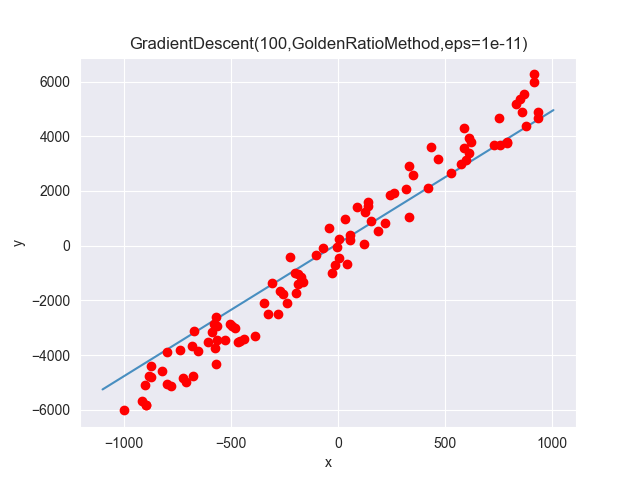

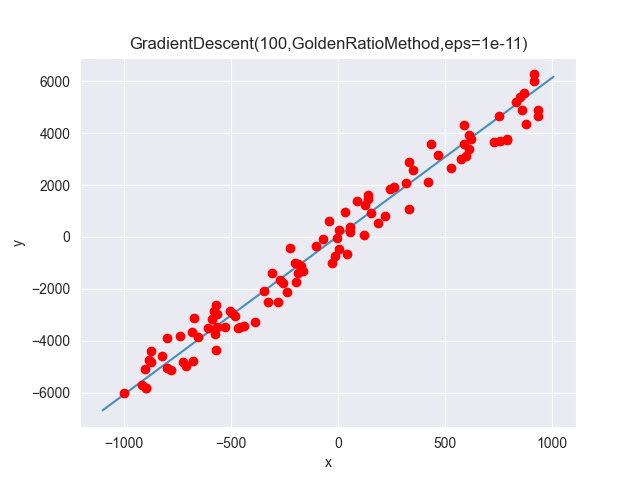

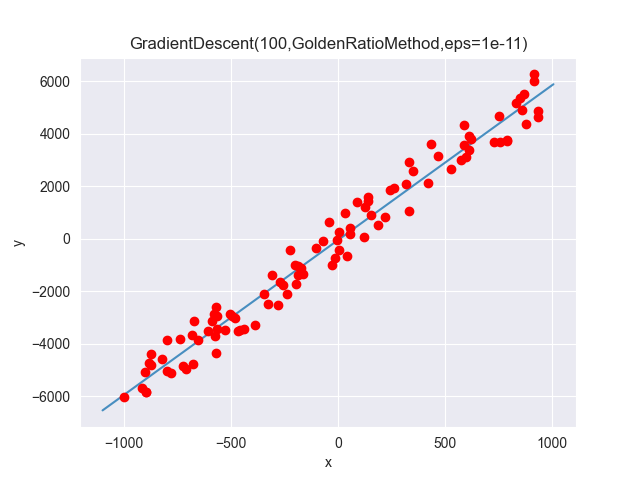

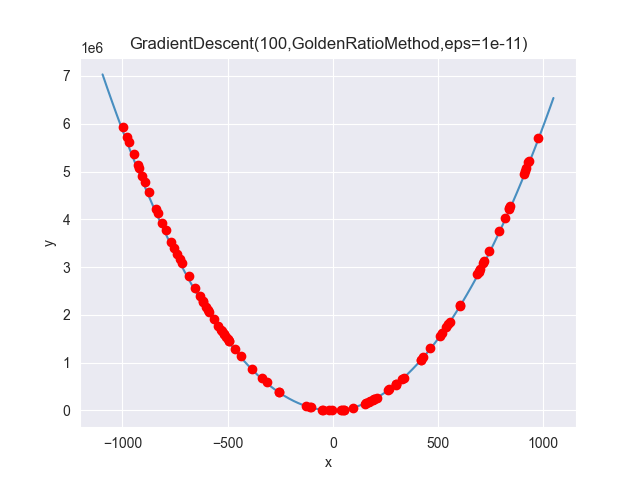

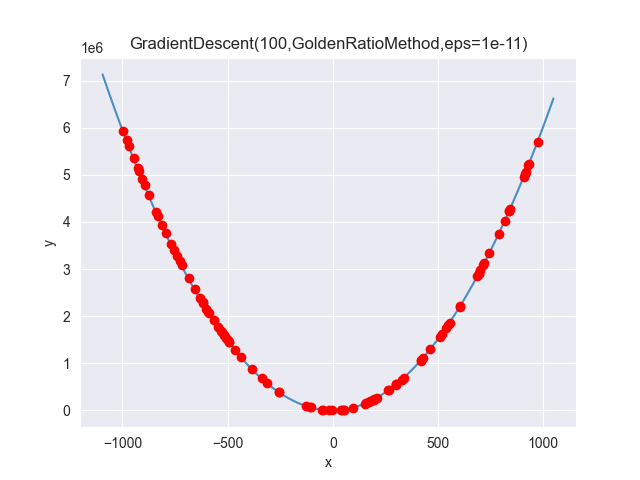

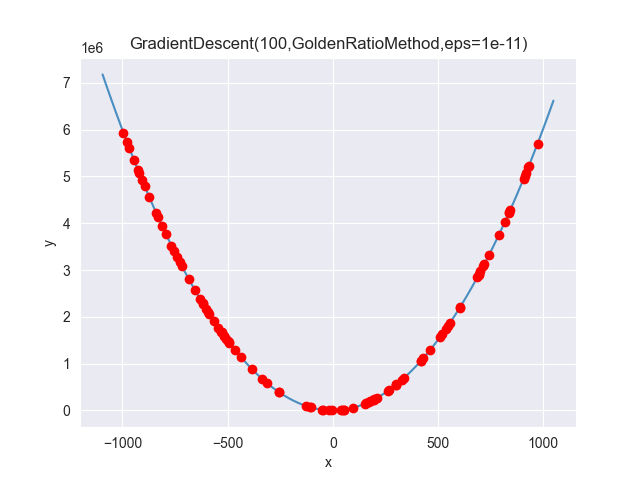

In [7]:
st = time.time()
result = Runner.run(methods, [linear_min_oracul, linear_oracul, linear_max_oracul, polynomial_min_oracul, polynomial_oracul, polynomial_max_oracul], point, modules, precision=defPrec,
                 # **FULL_DEBUG,
                 **TABLE,
                 **VISUALIZE,
                 # **FULL_VISUALIZE,
                 # **FULL_ANIMATION,
                 **VISUALIZE_FUNCTION
                 )

print(time.time() - st)

Поведение метода в целом соответствует ожиданиям. При минимальном размере существенно снижается время обучения, тем не менее значительно страдает точность. Даже на графиках заметно существенное отклонение от целевой функции. Другой крайностью является взятие в качестве batch_size размера выборки(фактически градиентный спуск): несмотря на существенное возрастание времени обучения, улучшения точности незначительны в сравнении с представителем промежуточного batch_size. Таким образом, подтверждается теоритическое предположение о большей вычислительной эффективности SGD в сравнении с GD при незначительной потере точности.
Также стоит заметить, что поведение методов сходно для случаев регрессии разных целевых функций, что является ожидаемым,  ведь подобный переход представляет из себя лишь добавление одного параметры

Тем не менее, стоит проверить, сохранится ли поведение методов на более сложных задачах. В качестве подобной задачи рассмотрим проблему поиска прямой, разделяющей два множества. Для начала, сгенерируем множества

In [8]:
import matplotlib.pyplot as plt
def gen_areas(per_class, areas):
    res = []
    counter = 0
    for i in areas:
        for j in range(per_class):
            res += [[random.uniform(i[0], i[1]), random.uniform(i[2], i[3]), counter]]
        counter += 1
    return res
def get_data(temp, dim):
    x = []
    y = []
    for j in temp:
        if j[2] == dim:
            x += [j[0]]
            y += [j[1]]
    return x, y

groups = gen_areas(100, [[-100, 100, -100, 100], [200, 500, 200, 500]])

Также потребуется изменить функцию ошибки. Ошибку будем считать следующим образом: если точка находится с нужной стороны от прямой, то ошибка считается приблизительно равной нулю. В противном же случае, ошибка растёт с ростом расстояния до прямой. Заметим так же, что при подобной постановке задачи, она может быть интерпретирована как бинарная классификация

In [18]:
conditions = [StepCountCondition(400)]
modules = ([ExecutionTime()]
           #+ [RAMSize()]
           + [EpochCount()]
           + metrics_base
           + conditions
           + [Animator()]
           )
primal_classes_oracul = MinimisingOracul(LineBinary(), LinearInterpretation(), groups, 25)
primal_classes_oracul_min = MinimisingOracul(LineBinary(), LinearInterpretation(), groups, 1)
primal_classes_oracul_max = MinimisingOracul(LineBinary(), LinearInterpretation(), groups, len(groups))
result_gr = Runner.run([GradientDescent(learning_rate=100, aprox_dec=1e-11)], [primal_classes_oracul_min, primal_classes_oracul, primal_classes_oracul_max], np.array([0, 30]), modules, precision=defPrec,
                    # **FULL_DEBUG,
                    **TABLE,
                    #**VISUALIZE,
                    # **FULL_VISUALIZE,
                    # **FULL_ANIMATION,
                    #**VISUALIZE_FUNCTION
                    )


MinimisingOracul
+--------------------------------------------------+-----------------+--------------+-------------+-------------+---------------------+-------------+
| Method name                                      |   ExecutionTime |   EpochCount |   StepCount |   CallCount |   GradientCallCount |   LossValue |
+==================================================+=================+==============+=============+=============+=====================+=============+
| GradientDescent(100,GoldenRatioMethod,eps=1e-11) |         1.52101 |            1 |         399 |       25935 |                 399 |      153153 |
+--------------------------------------------------+-----------------+--------------+-------------+-------------+---------------------+-------------+

MinimisingOracul
+--------------------------------------------------+-----------------+--------------+-------------+-------------+---------------------+-------------+
| Method name                                      |   Execution

In [19]:
def get_line_p(data):
    interpreter = LinearInterpretation()
    return [interpreter.interpret(data, np.array([500])), interpreter.interpret(data, np.array([-300]))]
def visualize(data, res):
    line = get_line_p(res)
    x, y = get_data(data, 0)
    axes = plt.figure().add_subplot()
    plt.axline([line[0][0], line[1][0]], [line[0][1], line[1][1]])
    axes.scatter(x, y, c ="green")
    x, y = get_data(data, 1)
    axes.scatter(x, y, c = "yellow") 
    plt.show()

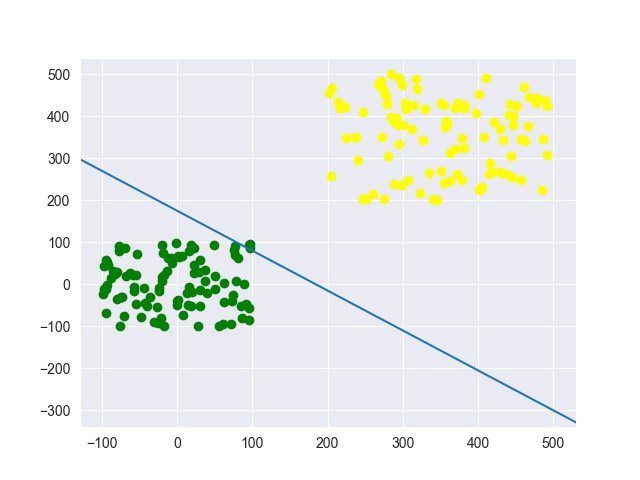

In [20]:
visualize(groups, result_gr[1][0][0][1])

Подчёркнутые в предыдущей серии сообенности поведения, сохраняются и в данных испытаниях. Впрочем, изменения в наблюдаемом поведении были бы скорее удивительны, ведь с точки зрения SGD ничего. кроме минимизируемой функции, не изменилось.
Последней из тестовых выборок для данного сегмента будет являться датасет регрессии. Задача - определение расхода топлива на милю по характеристикам машины.

In [12]:
import pandas as pd
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()
dataset = dataset[['Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin', 'MPG']]
dataset = dataset.dropna()
data_normal=(dataset-dataset.mean())/dataset.std()
data_normal.tail()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,MPG
393,-0.862911,-0.519972,-0.479835,-0.220842,0.021267,1.634321,-0.715726,0.455359
394,-0.862911,-0.930889,-1.363154,-0.997859,3.283479,1.634321,0.525711,2.633448
395,-0.862911,-0.567753,-0.531795,-0.803605,-1.428605,1.634321,-0.715726,1.095974
396,-0.862911,-0.711097,-0.661694,-0.415097,1.108671,1.634321,-0.715726,0.583482
397,-0.862911,-0.720653,-0.583754,-0.303253,1.398646,1.634321,-0.715726,0.967851


Прежде чем переёти непосредственно к регресии, ознакомимся с данными самостоятельно. Для этого построим парные графики для наиболее интересных нам значений

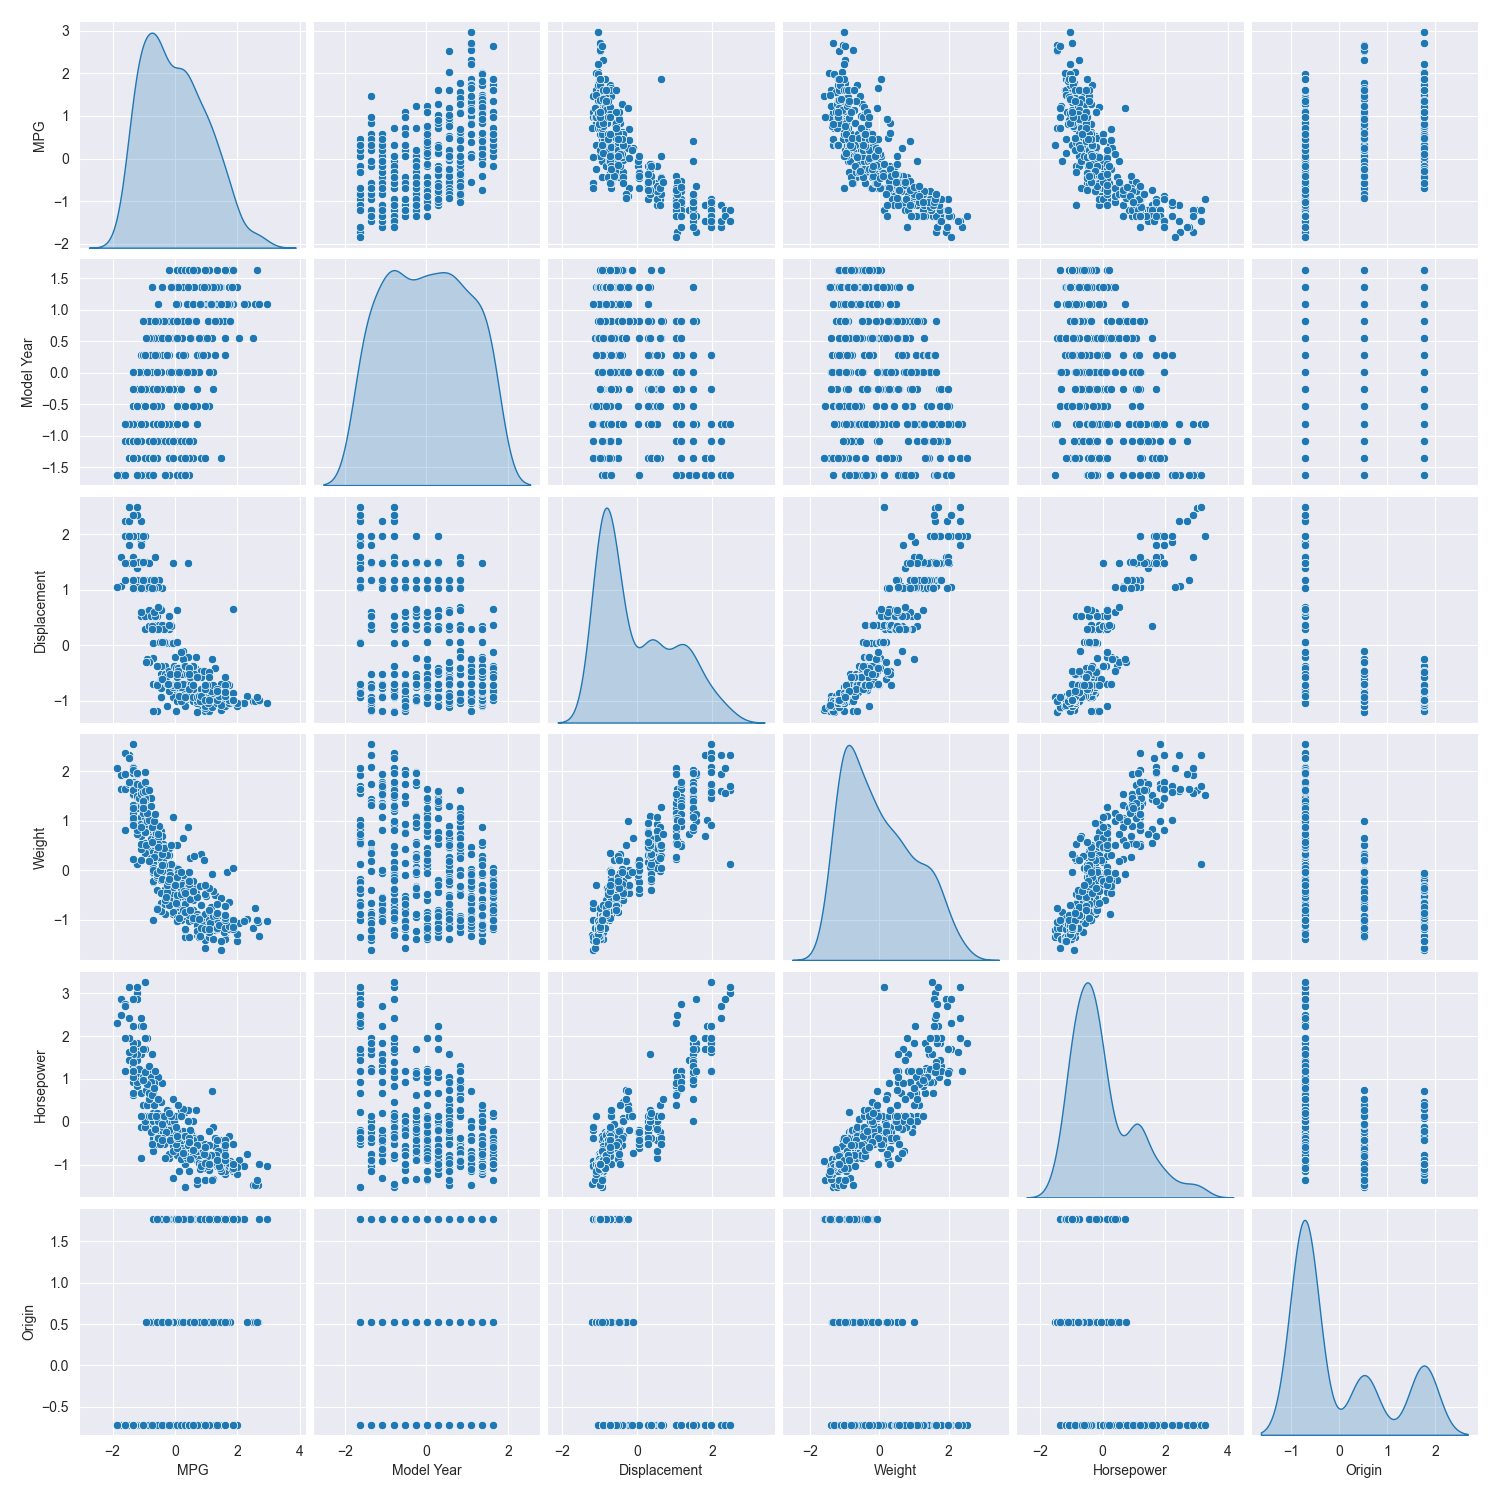

In [13]:
sns.pairplot(data_normal[['MPG', 'Model Year', 'Displacement', 'Weight', 'Horsepower', 'Origin']], diag_kind='kde')

In [14]:
data_normal_np = data_normal.to_numpy()
mpg_regress = MinimisingOracul(MSE(), MultiLinearInterpretation(7), data_normal_np, 30)
result = Runner.run([GradientDescent(learning_rate=100, aprox_dec=1e-11)], [mpg_regress], np.array([1, 1, 1, 1, 1, 1, 1, 1]), modules, precision=defPrec,
                    # **FULL_DEBUG,
                    **TABLE,
                    #**VISUALIZE,
                    # **FULL_VISUALIZE,
                    # **FULL_ANIMATION,
                    #**VISUALIZE_FUNCTION
                    )


MinimisingOracul
+--------------------------------------------------+-----------------+--------------+-------------+-------------+---------------------+-------------+
| Method name                                      |   ExecutionTime |   EpochCount |   StepCount |   CallCount |   GradientCallCount |   LossValue |
+==================================================+=================+==============+=============+=============+=====================+=============+
| GradientDescent(100,GoldenRatioMethod,eps=1e-11) |         79.9115 |           28 |         399 |       25935 |                 399 |    0.180214 |
+--------------------------------------------------+-----------------+--------------+-------------+-------------+---------------------+-------------+


Визуализация семимерного пространства, по очевидным причинам, видится затруднительной, потому, как и при расссмотрении данных, попробуем взглянуть на двумерную проекцию результатов

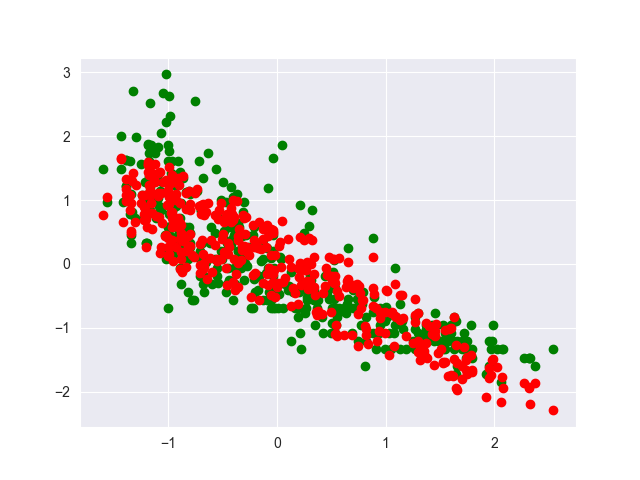

In [15]:
def get_line_p(res, point, ind):
    return point[ind], MultiLinearInterpretation(7).interpret(res, point)[-1]
x = data_normal['Weight']
y = data_normal['MPG']
axes = plt.figure().add_subplot()
points_x = []
points_y = []
for i in data_normal_np:
    t_x, t_y = get_line_p(result[0][0][0][1], i[0:7], 3)
    points_x += [t_x]
    points_y += [t_y]
axes.scatter(x, y, c ="green")
axes.scatter(points_x, points_y, c ="red")
plt.show()
plt.close()

Несложно заметить как линейный паттерн распределния результатов, так и сходность очетаний предсказываемыз величин и реальных. В совокупности с весьма малым значением функции лосса и рассмотрением других проекций (не представленных в данном отчёте ввиду меньшей их значимости и в угоду большей компактности), это позволяет сделать заключение об успешном выполнении алгоритмом своих задач на массиве реальных данных. Что немаловажно, ввиду его простоты, мы можем понять, какие данные наиболее значимы для предсказываемого значения

In [16]:
result[0][0][0][1]

array([-0.04997454,  0.24283429, -0.0838685 , -0.72801373,  0.06224746,
        0.36808484,  0.12674895, -0.02078473])

Несложно заметить, что наиболее важным алгоритму видится вес автомобиля (притом берётся он с отрицательным коэффициентом) - подобныя зависимость, если задуматься, весьма очевидна, заметна она и на графиках совместного распределения, тем не менее, тот факт, что модель распознала подобную закономерность видится примечательным. Менее тривиальную зависимость можно заметить в параметре под номером 5. Он соответствует году выпуска. При обращении к парным распределениям, вновь можно заметить тенденцию роста показателя MPG с увеличением года выпуска. Остальные же параметры вносят вклад не столь значительный (а страна выпуска или число цилиндров - так и вовсе почти не влияют на результат). Таким образом, даже столь примитивная модель может быть полезна в выявлении закономерностей.

Использованные ранее датасеты, ввиду довольно полного покрытия ими задач линейной регрессии, будут и далее служить нам мерилом эффективности при рассмотрении различных модификаций метода SGD, исследованию коего и посвящена данная работа. Хотя, конечно, для внесения минимального разнообразия, там, где это возможно и осмысленно, в рассматриваемые задачи будут внесены изменения

In [46]:
def epoch_base_sheduler(base_rate, state, decay):
    return base_rate * (1 /(1 + decay * state.epoch))
def step_base_sheduler(base_rate, state, decay, steps):
    return base_rate * (1 /(1 + decay * ((state.epoch * steps) + state.step)))

0.9900990099009901
0.9803921568627451
0.970873786407767
0.9615384615384615
0.9523809523809523
0.9433962264150942
0.9345794392523364
0.9259259259259258
0.9174311926605504
0.9090909090909091
0.9009009009009008
0.8928571428571428
0.8849557522123894
0.8771929824561403
0.8695652173913044
0.8620689655172414
0.8547008547008548
0.8474576271186441
0.8403361344537815
0.8333333333333334
0.8264462809917356
0.819672131147541
0.8130081300813008
0.8064516129032259
0.8
0.7936507936507936
0.7874015748031495
0.78125
0.7751937984496123
0.7692307692307692
0.7633587786259541
0.7575757575757576
0.7518796992481203
0.7462686567164178
0.7407407407407407
0.7352941176470589
0.7299270072992701
0.7246376811594204
0.7194244604316546
0.7142857142857143
0.7092198581560283
0.7042253521126761
0.6993006993006994
0.6944444444444444
0.6896551724137931
0.684931506849315
0.6802721088435374
0.6756756756756757
0.6711409395973155
0.6666666666666666
0.6622516556291391
0.6578947368421053
0.6535947712418301
0.6493506493506493
0.6

C:\Users\12345\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


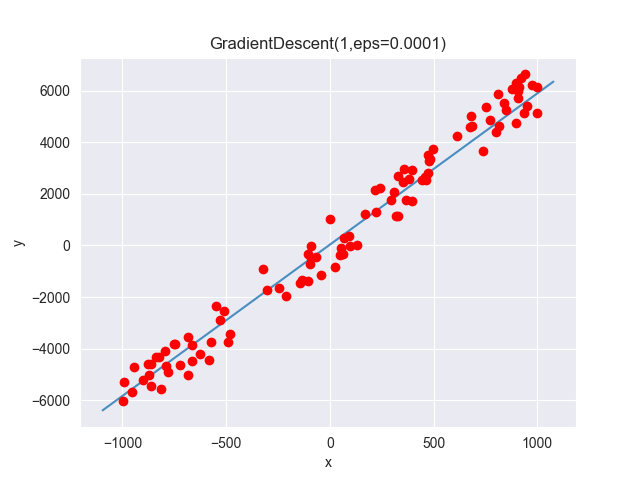

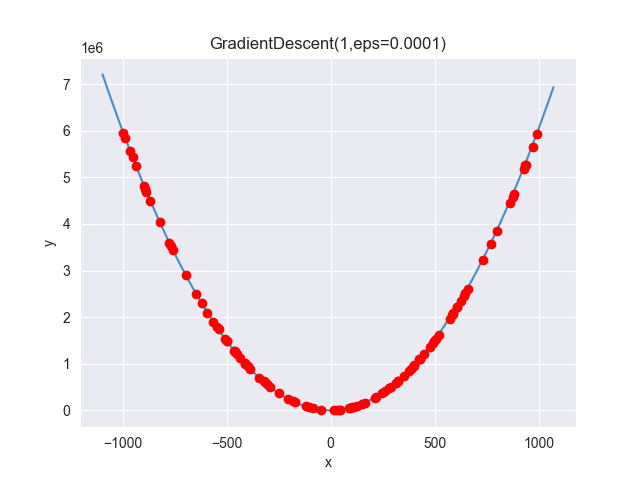

In [47]:
result = Runner.run([GradientDescentBase(), GradientDescentSheduled(lambda a, b: epoch_base_sheduler(a, b, 0.5), 1), GradientDescentSheduled(lambda a, b: step_base_sheduler(a, b, 0.01, 5), 1)], [linear_oracul, polynomial_oracul], point, modules, precision=defPrec,
                 # **FULL_DEBUG,
                 **TABLE,
                 **VISUALIZE,
                 # **FULL_VISUALIZE,
                 # **FULL_ANIMATION,
                 **VISUALIZE_FUNCTION
                 )